In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

### Loading the images into tensorflow pipeline

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Deep Learning Project/Traning/Potato Village",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato early blight', 'Potato healthy', 'Potato late blight']

In [5]:
len(dataset) # Every element in the dataset is a batch of 32 images so 68*32 = 2176 files which is nearly correct

68

#### (1) Ploting the images

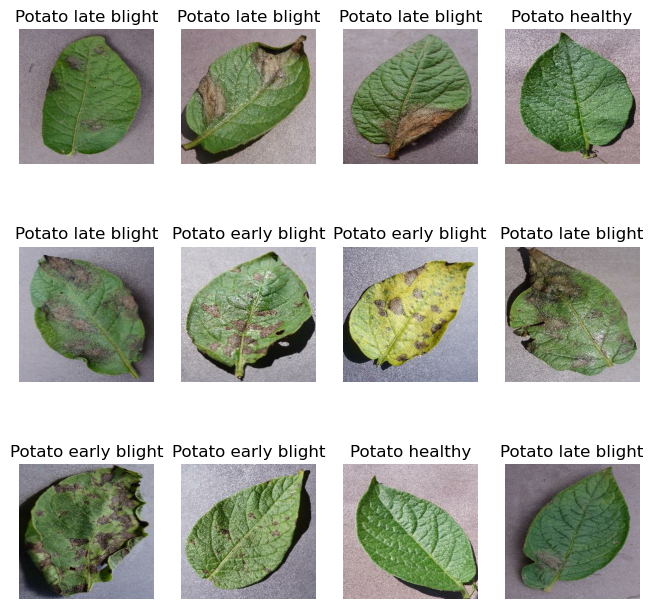

In [6]:
plt.figure(figsize=(8, 8))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [7]:
train_size = 0.8
len(dataset)*train_size 

54.400000000000006

80% ==> traning

20% ==> 10% validation, 10% test

In [8]:
len(dataset) # Every element in the dataset is a batch of 32 images so 68*32 = 2176 images which is nearly correct

68

In [9]:
train_ds = dataset.take(54)
len(train_ds) # We will take 54 training samples

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds) # We will take 14 testing samples

14

In [11]:
val_size = 0.1
len(dataset)*val_size 

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds) # We will take 6 validation samples

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds) # That will be out actual test dataset 

8

### (2) Train Test Split of Data

In [14]:
# We are now going to convert the above hard coded values into a nice function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [17]:
# Cache will save the image in memory if it is needed againa and prefetch will make the data available for the next batch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

### Convolution Neural Network Building

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
CNN = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

CNN.build(input_shape=input_shape)

In [22]:
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [23]:
CNN.compile(optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

In [24]:
EPOCHS = 15
history = CNN.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds,
    verbose=1
)

Epoch 1/15
54/54 [==============================] - 262s 4s/step - loss: 0.8717 - accuracy: 0.5185 - val_loss: 0.7357 - val_accuracy: 0.6719
Epoch 2/15
54/54 [==============================] - 255s 5s/step - loss: 0.6821 - accuracy: 0.7008 - val_loss: 0.6404 - val_accuracy: 0.6875
Epoch 3/15
54/54 [==============================] - 234s 4s/step - loss: 0.4122 - accuracy: 0.8420 - val_loss: 0.4829 - val_accuracy: 0.7656
Epoch 4/15
54/54 [==============================] - 233s 4s/step - loss: 0.2817 - accuracy: 0.8941 - val_loss: 0.6488 - val_accuracy: 0.6875
Epoch 5/15
54/54 [==============================] - 232s 4s/step - loss: 0.2135 - accuracy: 0.9230 - val_loss: 0.3382 - val_accuracy: 0.8594
Epoch 6/15
54/54 [==============================] - 264s 5s/step - loss: 0.1222 - accuracy: 0.9560 - val_loss: 0.5427 - val_accuracy: 0.7812
Epoch 7/15
54/54 [==============================] - 267s 5s/step - loss: 0.1297 - accuracy: 0.9497 - val_loss: 0.7785 - val_accuracy: 0.7396
Epoch 8/15
54

In [25]:
score = CNN.evaluate(test_ds)
score

8/8 [==============================] - 6s 391ms/step - loss: 0.0396 - accuracy: 0.9805


[0.03960511088371277, 0.98046875]

In [26]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history.history['accuracy'] # As you can see we have only run one epoch so it has only stored one accuracy in it.

[0.5185185074806213,
 0.7008101940155029,
 0.8420138955116272,
 0.8940972089767456,
 0.9230324029922485,
 0.9560185074806213,
 0.9496527910232544,
 0.9594907760620117,
 0.9658564925193787,
 0.9612268805503845,
 0.9560185074806213,
 0.9768518805503845,
 0.9762731790542603,
 0.9641203880310059,
 0.9774305820465088]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
 
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Traning and Validation Accuracy')

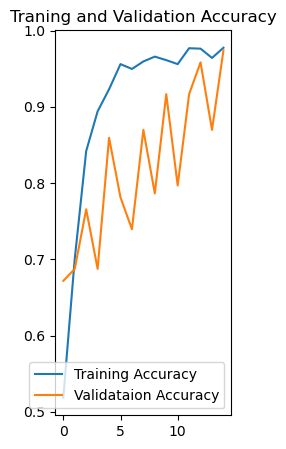

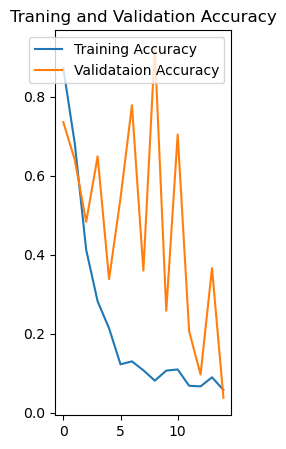

In [31]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validataion Accuracy'),
plt.legend(loc = 'lower right')
plt.title('Traning and Validation Accuracy')

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label='Validataion Accuracy'),
plt.legend(loc = 'upper right')
plt.title('Traning and Validation Accuracy')

First image to predict
Actual label: Potato late blight
1/1 [==============================] - 0s 74ms/step
Predicted Lable : Potato late blight


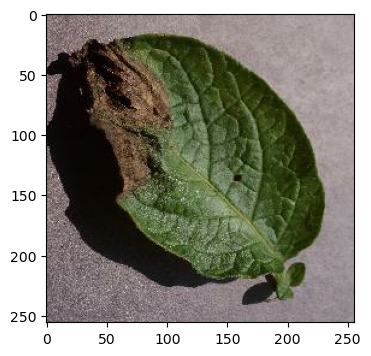

In [46]:
plt.figure(figsize=(4, 4))
import numpy as np

for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual label:', class_names[first_label])
    
    batch_predictions = CNN.predict(image_batch)
    print("Predicted Lable :",class_names[np.argmax(batch_predictions[0])])
    

In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # convert image to array
    img_array = tf.expand_dims(img_array, 0) # Create a batch of image
    
    predictions = CNN.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


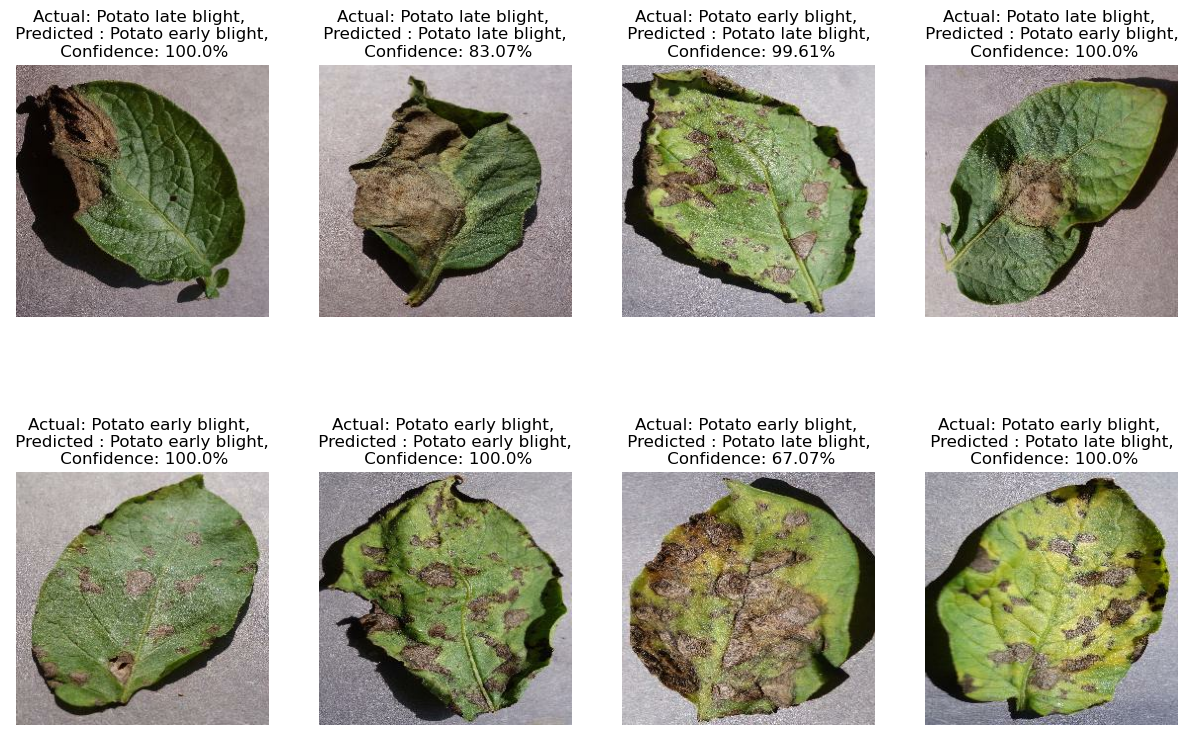

In [60]:
plt.figure(figsize=(15, 15))
for images, label in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(CNN, images[i].numpy())
        actual_class = class_names[labels_batch[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted : {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis('off')

In [ ]:
model_version = 1
CNN.save(f"./Deep Learning Project/Models/{model_version}")